In [1]:
# base modules
import os
import sys
import copy

# for manipulating data
import numpy as np
import pandas as pd
import math
import joblib
import gc


# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE


# for visualization
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
# for package auto reload
%load_ext autoreload
%autoreload 2

# for better rendering of plots in jupyter notebook
%matplotlib inline

### Select Data 

In [3]:
# read the data in chunk

chunk_size = 100000
train_chunks = pd.read_csv('train.csv', chunksize=chunk_size)

for chunk in train_chunks:
    print(chunk.info(memory_usage='deep'))
    print(chunk.head())
    break

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                100000 non-null  float64
 1   click             100000 non-null  int64  
 2   hour              100000 non-null  int64  
 3   C1                100000 non-null  int64  
 4   banner_pos        100000 non-null  int64  
 5   site_id           100000 non-null  object 
 6   site_domain       100000 non-null  object 
 7   site_category     100000 non-null  object 
 8   app_id            100000 non-null  object 
 9   app_domain        100000 non-null  object 
 10  app_category      100000 non-null  object 
 11  device_id         100000 non-null  object 
 12  device_ip         100000 non-null  object 
 13  device_model      100000 non-null  object 
 14  device_type       100000 non-null  int64  
 15  device_conn_type  100000 non-null  int64  
 16  C14               100

In [4]:
# random select
sample_ratio = 0.01  # select 1% each time

# sampling
sampled_data = pd.DataFrame()
for chunk in pd.read_csv('train.csv', chunksize=chunk_size):
    sampled_chunk = chunk.sample(frac=sample_ratio, random_state=42)
    sampled_data = pd.concat([sampled_data, sampled_chunk], ignore_index=True)

print(f"the size of sampled data: {sampled_data.shape}")


the size of sampled data: (404290, 24)


In [5]:
# optimization

def optimize_memory(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='unsigned')
        elif df[col].dtype == 'object':
            df[col] = df[col].astype('category')
    return df

sampled_data = optimize_memory(sampled_data)

print(sampled_data.info(memory_usage='deep'))

/Users/jenny/anaconda3/envs/MLP_Project/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:378: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   id                404290 non-null  uint64  
 1   click             404290 non-null  uint8   
 2   hour              404290 non-null  uint32  
 3   C1                404290 non-null  uint16  
 4   banner_pos        404290 non-null  uint8   
 5   site_id           404290 non-null  category
 6   site_domain       404290 non-null  category
 7   site_category     404290 non-null  category
 8   app_id            404290 non-null  category
 9   app_domain        404290 non-null  category
 10  app_category      404290 non-null  category
 11  device_id         404290 non-null  category
 12  device_ip         404290 non-null  category
 13  device_model      404290 non-null  category
 14  device_type       404290 non-null  uint8   
 15  device_conn_type  404290 non-null  uint8   
 16  C1

In [6]:
# save as a csv file
sampled_data.to_csv('train_sample.csv', index=False, compression='gzip')

### Data Processing

In [7]:
df = pd.read_csv('train_sample.csv', compression='gzip')
df

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3926754196077507072,1,14102100,1005,0,f84e52b6,d7e2f29b,28905ebd,ecad2386,7801e8d9,...,1,0,20346,300,250,2331,2,39,-1,23
1,4544181857823990784,1,14102100,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17037,320,50,1934,2,39,-1,16
2,12744445434029488128,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,100083,79
3,4063799378381284352,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15699,320,50,1722,0,35,-1,79
4,6357775859397618688,1,14102100,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,17654,300,250,1994,2,39,100083,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,9823785328714326016,0,14103023,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22254,320,50,2545,0,431,100084,221
404286,5655954353396606976,1,14103023,1005,1,17caea14,0dde25ec,f028772b,ecad2386,7801e8d9,...,1,0,21412,320,50,2467,2,167,100081,23
404287,5360327371237894144,0,14103023,1002,0,61a8c644,c4e18dd6,50e219e0,ecad2386,7801e8d9,...,0,0,21789,320,50,2512,2,291,-1,52
404288,8782688772576775168,1,14103023,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22254,320,50,2545,0,431,-1,221


In [8]:
# get information of time 

df['hour'] = pd.to_datetime(df['hour'].astype(str), format='%y%m%d%H')  

df['day'] = df['hour'].dt.day  

df['weekday'] = df['hour'].dt.weekday
df['is_weekend'] = df['hour'].dt.isocalendar().day >= 6  

df['hour'] = df['hour'].dt.hour  
df['is_morning'] = df['hour'].between(6, 12)
df['is_afternoon'] = df['hour'].between(12, 18)
df['is_evening'] = df['hour'].between(18, 24)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [9]:
# category

categorical_columns = [
    'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category',
    'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type'
]

label_encoders = {}

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

In [10]:
missing_summary = df.isnull().sum()
print("missing：\n", missing_summary[missing_summary > 0])

df.fillna(-1, inplace=True)

missing：
 Series([], dtype: int64)


In [11]:
for col in ['C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']:
    label_enc = LabelEncoder()
    df[col] = label_enc.fit_transform(df[col])


In [12]:
df['site_app_combination'] = df['site_category'] * 1000 + df['app_category']  
df['device_interaction'] = df['device_type'] * 10 + df['device_conn_type']   


In [13]:
df['site_category_count'] = df.groupby('site_category')['click'].transform('count')  
df['app_category_mean_click'] = df.groupby('app_category')['click'].transform('mean')  


In [14]:
df['site_device_combination'] = df['site_id'] * 100 + df['device_type']
df['app_conn_combination'] = df['app_category'] * 10 + df['device_conn_type']
df['site_app_device'] = df['site_category'] * 1000 + df['app_category'] * 10 + df['device_type']


In [15]:
df['site_click_rate'] = df.groupby('site_id')['click'].transform('mean')
df['app_click_rate'] = df.groupby('app_id')['click'].transform('mean')

df['site_count'] = df.groupby('site_id')['click'].transform('count')
df['app_count'] = df.groupby('app_id')['click'].transform('count')


In [16]:
df['device_type_conn_interaction'] = df['device_type'] * df['device_conn_type']
df['C14_C17_product'] = df['C14'] * df['C17']


In [17]:
df['device_click_rate'] = df.groupby('device_id')['click'].transform('mean')
df['device_count'] = df.groupby('device_id')['click'].transform('count')


In [18]:
df['site_app_click_rate'] = df.groupby(['site_category', 'app_category'])['click'].transform('mean')


In [19]:
df['combined_feature'] = df['C14'] * 100 + df['C17']


In [20]:
df['C14_log'] = np.log1p(df['C14'])  
df['C15_C16_ratio'] = df['C15'] / (df['C16'] + 1)  


### Data Modeling

In [21]:
X = df.drop(columns=['click'])
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"The size of train: {X_train.shape}, The size of test: {X_test.shape}")

The size of train: (323432, 50), The size of test: (80858, 50)


In [22]:
# The basic model

ctr = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

ctr.fit(X_train, y_train)

y_pred = ctr.predict(X_test)
y_pred_proba = ctr.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


AUC: 0.8150
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     67228
           1       0.84      0.20      0.33     13630

    accuracy                           0.86     80858
   macro avg       0.85      0.60      0.62     80858
weighted avg       0.86      0.86      0.82     80858



In [23]:
# class weight

ctr_balanced = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1, 
    class_weight='balanced'
)

ctr_balanced.fit(X_train, y_train)

y_pred_balanced = ctr_balanced.predict(X_test)
y_pred_proba_balanced = ctr_balanced.predict_proba(X_test)[:, 1]

auc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
print(f"AUC: {auc_balanced:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_balanced))


AUC: 0.8163
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     67228
           1       0.32      0.82      0.46     13630

    accuracy                           0.67     80858
   macro avg       0.63      0.73      0.61     80858
weighted avg       0.84      0.67      0.71     80858



In [24]:
# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_balanced)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"The best: {optimal_threshold:.2f}")

y_pred_adjusted = (y_pred_proba_balanced >= optimal_threshold).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))


The best: 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.66      0.78     67228
           1       0.33      0.80      0.46     13630

    accuracy                           0.69     80858
   macro avg       0.63      0.73      0.62     80858
weighted avg       0.84      0.69      0.73     80858



In [25]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ctr_balanced.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance(Top 10):")
print(feature_importances.head(10))

low_importance_features = feature_importances[feature_importances['Importance'] < 0.01]['Feature'].tolist()
print(f"Low Feature Importance: {low_importance_features}")


Feature Importance(Top 10):
                    Feature  Importance
44        device_click_rate    0.330231
38          site_click_rate    0.164740
39           app_click_rate    0.109305
45             device_count    0.027800
40               site_count    0.026068
34  app_category_mean_click    0.020690
22                      C21    0.020470
10                device_id    0.019548
46      site_app_click_rate    0.019021
17                      C16    0.017736
Low Feature Importance: ['app_conn_combination', 'site_id', 'C14_log', 'C14', 'C18', 'device_interaction', 'C15', 'site_app_combination', 'C14_C17_product', 'C1', 'device_type', 'C20', 'C17', 'site_category', 'app_category', 'app_domain', 'C19', 'site_category_count', 'hour', 'banner_pos', 'device_model', 'id', 'device_ip', 'hour_sin', 'device_conn_type', 'device_type_conn_interaction', 'hour_cos', 'day', 'is_evening', 'weekday', 'is_afternoon', 'is_morning', 'is_weekend']


In [26]:
# remove the Low Feature Importance
X_train_optimized = X_train.drop(columns=low_importance_features)
X_test_optimized = X_test.drop(columns=low_importance_features)

In [27]:
ctr_optimized = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

ctr_optimized.fit(X_train_optimized, y_train)

# 预测
y_pred_optimized = ctr_optimized.predict(X_test_optimized)
y_pred_proba_optimized = ctr_optimized.predict_proba(X_test_optimized)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_optimized))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     67228
           1       0.31      0.84      0.45     13630

    accuracy                           0.65     80858
   macro avg       0.63      0.73      0.60     80858
weighted avg       0.84      0.65      0.70     80858

AUC: 0.8155


In [28]:
time_features = ['hour_sin', 'hour_cos', 'hour', 'weekday', 'is_weekend']
X_train_restored = X_train_optimized.join(X_train[time_features])
X_test_restored = X_test_optimized.join(X_test[time_features])

In [29]:
ctr_restored = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
ctr_restored.fit(X_train_restored, y_train)

y_pred_restored = ctr_restored.predict(X_test_restored)
y_pred_proba_restored = ctr_restored.predict_proba(X_test_restored)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_restored))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_restored):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     67228
           1       0.32      0.82      0.46     13630

    accuracy                           0.67     80858
   macro avg       0.63      0.73      0.61     80858
weighted avg       0.84      0.67      0.71     80858

AUC: 0.8156


In [30]:
X_train_interactions = X_train_restored.copy()
X_test_interactions = X_test_restored.copy()

X_train_interactions['click_rate_interaction'] = X_train_interactions['device_click_rate'] * X_train_interactions['site_click_rate']
X_test_interactions['click_rate_interaction'] = X_test_interactions['device_click_rate'] * X_test_interactions['site_click_rate']

In [31]:
ctr_interactions = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
ctr_interactions.fit(X_train_interactions, y_train)

y_pred_interactions = ctr_interactions.predict(X_test_interactions)
y_pred_proba_interactions = ctr_interactions.predict_proba(X_test_interactions)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_interactions))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_interactions):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     67228
           1       0.32      0.82      0.46     13630

    accuracy                           0.67     80858
   macro avg       0.63      0.73      0.61     80858
weighted avg       0.84      0.67      0.71     80858

AUC: 0.8164


In [32]:
rf_complex = RandomForestClassifier(
    n_estimators=300,  
    max_depth=15,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_complex.fit(X_train_interactions, y_train)

y_pred_complex = rf_complex.predict(X_test_interactions)
y_pred_proba_complex = rf_complex.predict_proba(X_test_interactions)[:, 1]


print("Classification Report:")
print(classification_report(y_test, y_pred_complex))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_complex):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     67228
           1       0.33      0.79      0.46     13630

    accuracy                           0.69     80858
   macro avg       0.63      0.73      0.62     80858
weighted avg       0.84      0.69      0.73     80858

AUC: 0.8161


In [33]:
#validat by using RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=10,  # 控制随机搜索的次数
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_interactions, y_train)

best_rf = random_search.best_estimator_
print("The best parameters:")
print(random_search.best_params_)

y_pred_rs = best_rf.predict(X_test_interactions)
y_pred_proba_rs = best_rf.predict_proba(X_test_interactions)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print("Classification Report:")
print(classification_report(y_test, y_pred_rs))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_rs):.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.1s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   5.6s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   5.7s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   5.9s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END class_weight=balanced, max_depth=10, min_samples_leaf=1, mi

/Users/jenny/anaconda3/envs/MLP_Project/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The best parameters:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15, 'class_weight': 'balanced'}
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     67228
           1       0.33      0.79      0.46     13630

    accuracy                           0.69     80858
   macro avg       0.63      0.73      0.62     80858
weighted avg       0.84      0.69      0.73     80858

AUC: 0.8178


### Save Model

In [34]:
joblib.dump(rf_complex, 'final_random_forest_model.pkl')

loaded_model = joblib.load('final_random_forest_model.pkl')

y_pred_loaded = loaded_model.predict(X_test_interactions)
print("Classification Report:")
print(classification_report(y_test, y_pred_loaded))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     67228
           1       0.33      0.79      0.46     13630

    accuracy                           0.69     80858
   macro avg       0.63      0.73      0.62     80858
weighted avg       0.84      0.69      0.73     80858



### Model Interpretation

                    Feature  Importance
22   click_rate_interaction    0.310644
12        device_click_rate    0.176517
8           site_click_rate    0.109475
9            app_click_rate    0.088704
15         combined_feature    0.032176
13             device_count    0.031367
4                       C21    0.028850
14      site_app_click_rate    0.025695
10               site_count    0.018876
5   app_category_mean_click    0.017297


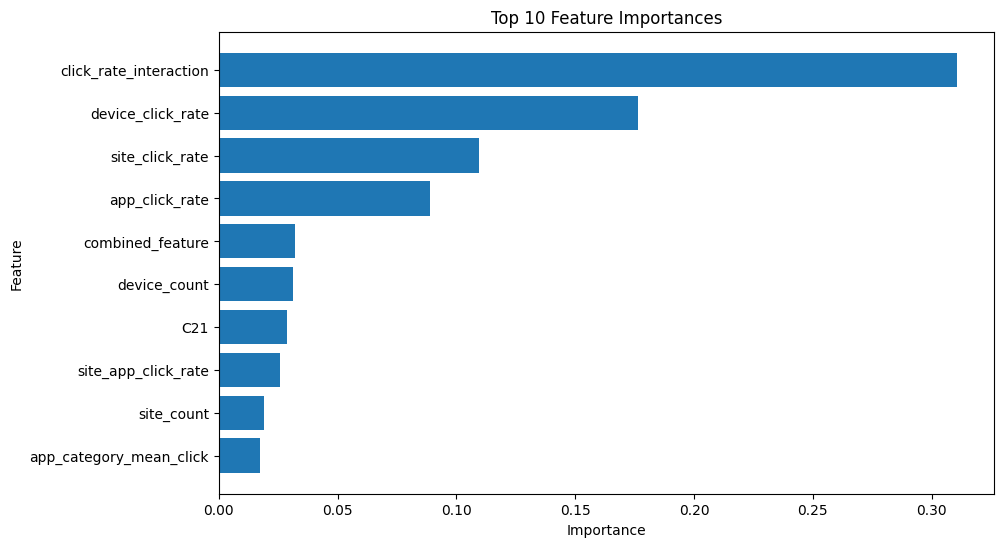

In [35]:
feature_importances = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


### Appendix

In [40]:
print(X_train_interactions.dtypes)

non_numeric_columns = X_train_interactions.select_dtypes(exclude=['int64', 'float64']).columns
print(f"非数值类型特征: {non_numeric_columns}")


site_domain                  int64
app_id                       int64
device_id                    int64
C16                          int64
C21                          int64
app_category_mean_click    float64
site_device_combination      int64
site_app_device              int64
site_click_rate            float64
app_click_rate             float64
site_count                   int64
app_count                    int64
device_click_rate          float64
device_count                 int64
site_app_click_rate        float64
combined_feature             int64
C15_C16_ratio              float64
hour_sin                   float64
hour_cos                   float64
hour                         int32
weekday                      int32
is_weekend                 boolean
click_rate_interaction     float64
dtype: object
非数值类型特征: Index(['hour', 'weekday', 'is_weekend'], dtype='object')


In [41]:
X_train_interactions = X_train_interactions.astype({col: 'int' for col in non_numeric_columns})


In [42]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in non_numeric_columns:
    le = LabelEncoder()
    X_train_interactions[col] = le.fit_transform(X_train_interactions[col])
    label_encoders[col] = le  


In [43]:
X_train_interactions = X_train_interactions.drop(columns=non_numeric_columns)
X_test_interactions = X_test_interactions.drop(columns=non_numeric_columns)

In [44]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_interactions, y_train)

print(f"The size of initial data: {X_train_interactions.shape}")
print(f"The size after SMOTE: {X_resampled.shape}")

The size of initial data: (323432, 20)
The size after SMOTE: (537106, 20)


In [45]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_interactions, y_train)

rf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_smote.fit(X_resampled, y_resampled)

y_pred_smote = rf_smote.predict(X_test_interactions)
y_pred_proba_smote = rf_smote.predict_proba(X_test_interactions)[:, 1]


print("Classification Report:")
print(classification_report(y_test, y_pred_smote))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     67228
           1       0.31      0.82      0.45     13630

    accuracy                           0.67     80858
   macro avg       0.63      0.73      0.61     80858
weighted avg       0.84      0.67      0.71     80858

AUC: 0.8148


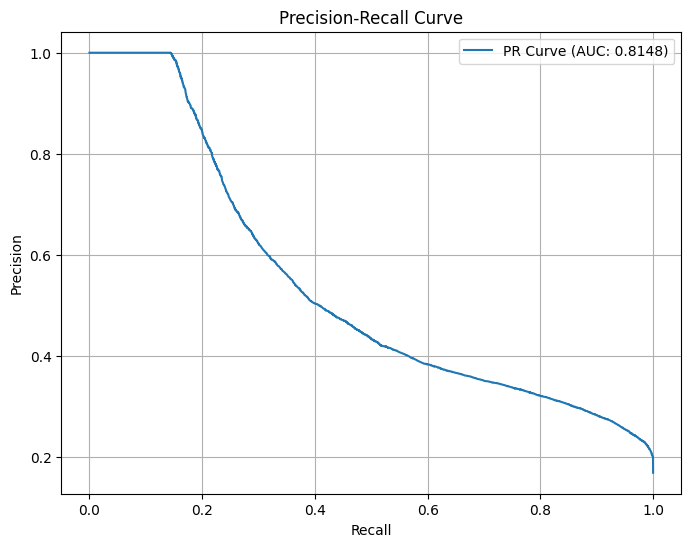

In [46]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_smote)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve (AUC: {:.4f})'.format(roc_auc_score(y_test, y_pred_proba_smote)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


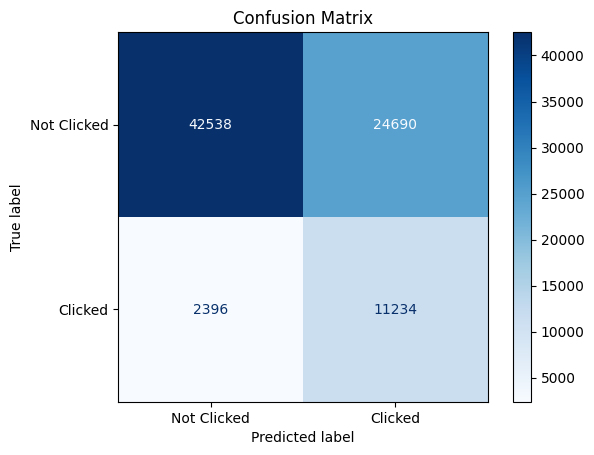

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred_smote)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Clicked', 'Clicked'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [48]:
from sklearn.metrics import precision_recall_curve, classification_report

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_smote)


f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"The best: {optimal_threshold:.2f}")


y_pred_adjusted = (y_pred_proba_smote >= optimal_threshold).astype(int)


print("Classification Report:")
print(classification_report(y_test, y_pred_adjusted))


The best: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     67228
           1       0.36      0.68      0.47     13630

    accuracy                           0.74     80858
   macro avg       0.64      0.72      0.65     80858
weighted avg       0.83      0.74      0.77     80858



In [49]:

feature_importances = pd.DataFrame({
    'Feature': X_train_interactions.columns,
    'Importance': rf_smote.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importances.head(10))


low_importance_features = feature_importances[feature_importances['Importance'] < 0.01]['Feature'].tolist()
X_train_filtered = X_train_interactions.drop(columns=low_importance_features)
X_test_filtered = X_test_interactions.drop(columns=low_importance_features)


rf_filtered = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_filtered.fit(X_train_filtered, y_train)


y_pred_filtered = rf_filtered.predict(X_test_filtered)
y_pred_proba_filtered = rf_filtered.predict_proba(X_test_filtered)[:, 1]
print("Classification Report:")
print(classification_report(y_test, y_pred_filtered))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_filtered):.4f}")


Feature Importance:
                    Feature  Importance
19   click_rate_interaction    0.357333
12        device_click_rate    0.178168
8           site_click_rate    0.114376
9            app_click_rate    0.095465
13             device_count    0.036088
14      site_app_click_rate    0.028613
5   app_category_mean_click    0.021551
10               site_count    0.018404
2                 device_id    0.017142
4                       C21    0.016791
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     67228
           1       0.32      0.82      0.46     13630

    accuracy                           0.67     80858
   macro avg       0.63      0.73      0.61     80858
weighted avg       0.84      0.67      0.71     80858

AUC: 0.8156


In [50]:
X_train_interactions['click_rate_interaction_sq'] = X_train_interactions['click_rate_interaction'] ** 2
X_test_interactions['click_rate_interaction_sq'] = X_test_interactions['click_rate_interaction'] ** 2

X_train_interactions['device_app_click_rate'] = X_train_interactions['device_click_rate'] * X_train_interactions['app_click_rate']
X_test_interactions['device_app_click_rate'] = X_test_interactions['device_click_rate'] * X_test_interactions['app_click_rate']

rf_interactions = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_interactions.fit(X_train_interactions, y_train)


y_pred_interactions = rf_interactions.predict(X_test_interactions)
y_pred_proba_interactions = rf_interactions.predict_proba(X_test_interactions)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_interactions))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_interactions):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     67228
           1       0.31      0.83      0.45     13630

    accuracy                           0.67     80858
   macro avg       0.63      0.73      0.61     80858
weighted avg       0.84      0.67      0.71     80858

AUC: 0.8167


In [51]:
from imblearn.combine import SMOTETomek


smote_tomek = SMOTETomek(random_state=42)
X_resampled_tomek, y_resampled_tomek = smote_tomek.fit_resample(X_train_interactions, y_train)


rf_smote_tomek = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_smote_tomek.fit(X_resampled_tomek, y_resampled_tomek)


y_pred_smote_tomek = rf_smote_tomek.predict(X_test_interactions)
y_pred_proba_smote_tomek = rf_smote_tomek.predict_proba(X_test_interactions)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_smote_tomek))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_smote_tomek):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     67228
           1       0.31      0.82      0.46     13630

    accuracy                           0.67     80858
   macro avg       0.63      0.73      0.61     80858
weighted avg       0.84      0.67      0.71     80858

AUC: 0.8152
